# Setup

In [0]:
!pip install easy-vqa>=1.0

In [2]:
from easy_vqa import get_train_questions, get_test_questions, get_answers
from easy_vqa import get_train_image_paths, get_test_image_paths
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Multiply, Embedding, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import numpy as np
from tqdm import tqdm

Using TensorFlow backend.


In [3]:
from google.colab import drive
import os

drive.mount('/content/drive/', force_remount=True)

PROJECT_LOC = ""

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Chirag
PROJECT_LOC = '/content/drive/My Drive/IIITD_Course/Sem_6/DL/DL_Group/Project_Easy_VQA'
os.chdir('/content/drive/My Drive/IIITD_Course/Sem_6/DL/DL_Group/Project_Easy_VQA')

In [0]:
# Prakhar
PROJECT_LOC = '/content/drive/My Drive/DL_Group/Project_Easy_VQA'
os.chdir('/content/drive/My Drive/DL_Group/Project_Easy_VQA')

In [0]:
# Akash
PROJECT_LOC = '/content/drive/My Drive/DL_Group/Project_Easy_VQA/Data'
# os.chdir('/content/drive/My Drive/DL/Project_Easy_VQA')

# Models

In [0]:
# Read question data
# (we already did this in the BOW section, remember?)
train_qs, train_answers, train_image_ids = get_train_questions()
test_qs, test_answers, test_image_ids = get_test_questions()

# Read answer data
all_answers = get_answers()
num_answers = len(all_answers)

In [0]:
def load_and_proccess_image(image_path):
  # Load image, then scale and shift pixel values to [-0.5, 0.5]
  im = img_to_array(load_img(image_path))
  return im / 255 - 0.5

def read_images(paths):
  # paths is a dict mapping image ID to image path
  # Returns a dict mapping image ID to the processed image
  ims = {}
  for image_id, image_path in paths.items():
    ims[image_id] = load_and_proccess_image(image_path)
  return ims

train_ims = read_images(get_train_image_paths())
test_ims = read_images(get_test_image_paths())

In [0]:
# Create model input images
train_X_ims = [train_ims[id] for id in train_image_ids]
test_X_ims = [test_ims[id] for id in test_image_ids]

# Create model outputs
train_answer_indices = [all_answers.index(a) for a in train_answers]
test_answer_indices = [all_answers.index(a) for a in test_answers]
train_Y = to_categorical(train_answer_indices)
test_Y = to_categorical(test_answer_indices)

In [0]:
# Fit tokenizer on the training questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_qs)

embedding_length = 10
embedding_dim = 50

# Convert questions to GloVe indices
train_X_seqs = pad_sequences(tokenizer.texts_to_sequences(train_qs), maxlen=embedding_length)
test_X_seqs = pad_sequences(tokenizer.texts_to_sequences(test_qs), maxlen=embedding_length)

# We add one because the Keras Tokenizer reserves index 0 and never uses it.
vocab_size = len(tokenizer.word_index) + 1

In [10]:
embedding_vector = {}
f = open('/content/drive/My Drive/DL_Group/Project_Easy_VQA/Data/glove.6B.50d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:], dtype = 'float32')
    embedding_vector[word] = coef

400000it [00:06, 58112.30it/s]


In [11]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word,i in tqdm(tokenizer.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 26/26 [00:00<00:00, 12006.15it/s]


In [12]:
# The CNN
im_input = Input(shape=(64, 64, 3))  
x1 = Conv2D(8, 3, padding='same')(im_input)
x1 = MaxPooling2D()(x1)
x1 = Conv2D(16, 3, padding='same')(x1)
x1 = MaxPooling2D()(x1)
x1 = Flatten()(x1)
# Add a final fully-connected layer after the CNN for good measure
x1 = Dense(32, activation='tanh')(x1)
print(x1)

Tensor("dense_1/Tanh:0", shape=(None, 32), dtype=float32)


In [0]:
## pretrained images# example of loading the resnet50 model

# example of loading the inception v3 model
# from keras.applications.inception_v3 import InceptionV3
# # load model
# from keras.layers.convolutional import UpSampling2D


###### heavy resnet


from keras.layers.normalization import BatchNormalization
from keras.layers import add
from keras.layers import Activation
from keras.layers import Dropout

im_input = Input(shape=(64, 64, 3))
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same")(temp)
    # temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("tanh")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same")(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same")(x)])
    # if pooling:
        # x = MaxPooling2D((2,2))(x)
    # if dropout != 0.0:
        # x = Dropout(dropout)(x)
    # x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    # x = Activation("relu")(x)
    return x

x1 = im_input
x1 = Conv2D(16,(3,3),strides = stride,padding = "same")(x1)
# x1 = BatchNormalization(axis = CHANNEL_AXIS)(x1)
# x1 = Activation("relu")(x1)
x1 = res_layer(x1,32,dropout = 0.2)
# x1 = res_layer(x1,32,dropout = 0.3)
x1 = res_layer(x1,32,dropout = 0.4,pooling = True)
# x1 = res_layer(x1,64,dropout = 0.2)
# x1 = res_layer(x1,64,dropout = 0.2,pooling = True)
# x1 = res_layer(x1,256,dropout = 0.4)
x1 = Flatten()(x1)
x1 = Dropout(0.4)(x1)
# x1 = Dense(64,activation = "relu")(x1)
# x1 = Dropout(0.23)(x1)
x1 = Dense(32,activation = "tanh")(x1)



In [0]:
## pretrained images# example of loading the resnet50 model

# example of loading the inception v3 model
# from keras.applications.inception_v3 import InceptionV3
# # load model
# from keras.layers.convolutional import UpSampling2D

#### RESNET 

from keras.layers.normalization import BatchNormalization
from keras.layers import add
from keras.layers import Activation
from keras.layers import Dropout

im_input = Input(shape=(64, 64, 3))
stride = 1
CHANNEL_AXIS = 3

x1 = im_input
x1 = Conv2D(3,(3,3),strides = 2)(x1)
x3 = Conv2D(3,(3,3),strides = stride,padding = "same")(x1)
x3 = Activation("tanh")(x3)
x3 = Conv2D(3,(3,3),strides = stride,padding = "same")(x3)
x1 = add([x1,x3])

x1 = Flatten()(x1)
x1 = Dropout(0.4)(x1)
x1 = Dense(32,activation = "tanh")(x1)



In [15]:
print(x1)

Tensor("dense_3/Tanh:0", shape=(None, 32), dtype=float32)


In [0]:
from keras.layers import Dense, Lambda, dot, Activation, concatenate

def attention_3d_block(hidden_states):
    """
    Many-to-one attention mechanism for Keras.
    @param hidden_states: 3D tensor with shape (batch_size, time_steps, input_dim).
    @return: 2D tensor with shape (batch_size, 128)
    """
    hidden_size = int(hidden_states.shape[2])
    # Inside dense layer
    #              hidden_states            dot               W            =>           score_first_part
    # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
    # W is the trainable weight matrix of attention Luong's multiplicative style score
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
    #            score_first_part           dot        last_hidden_state     => attention_weights
    # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
    score = dot([score_first_part, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)
    # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    return attention_vector

In [0]:
# The question network
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation, Reshape
q_input = Input(shape=(embedding_length,))
x2 = Embedding(vocab_size, embedding_dim, input_length=embedding_length, weights=[embedding_matrix], trainable=False)(q_input)
x2 = LSTM(100, return_sequences=True)(x2)
# x2 = attention_3d_block(x2)
x2 = Flatten()(x2)
x2 = Dense(64, activation='tanh')(x2)
x2 = Dense(32, activation='tanh')(x2)
# x2=(Reshape(input_shape = (x2.shape,), target_shape=(x2.shape,1)))

# Training

In [0]:
checkpoint = ModelCheckpoint(os.path.join(PROJECT_LOC,'glove-LSTM-attn-Resn-concat.h5'), save_best_only=True)

In [0]:
out = Concatenate()([x1, x2]) # from previous section
out = Dense(64, activation='tanh')(out)
# num_answers will be defined below
out = Dense(num_answers, activation='softmax')(out)

model = Model(inputs=[im_input, q_input], outputs=out)
model.compile(
  Adam(lr=1e-3), # somewhat arbitrarily chosen
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 31, 31, 3)    84          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 31, 31, 3)    84          conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 31, 31, 3)    0           conv2d_11[0][0]                  
____________________________________________________________________________________________

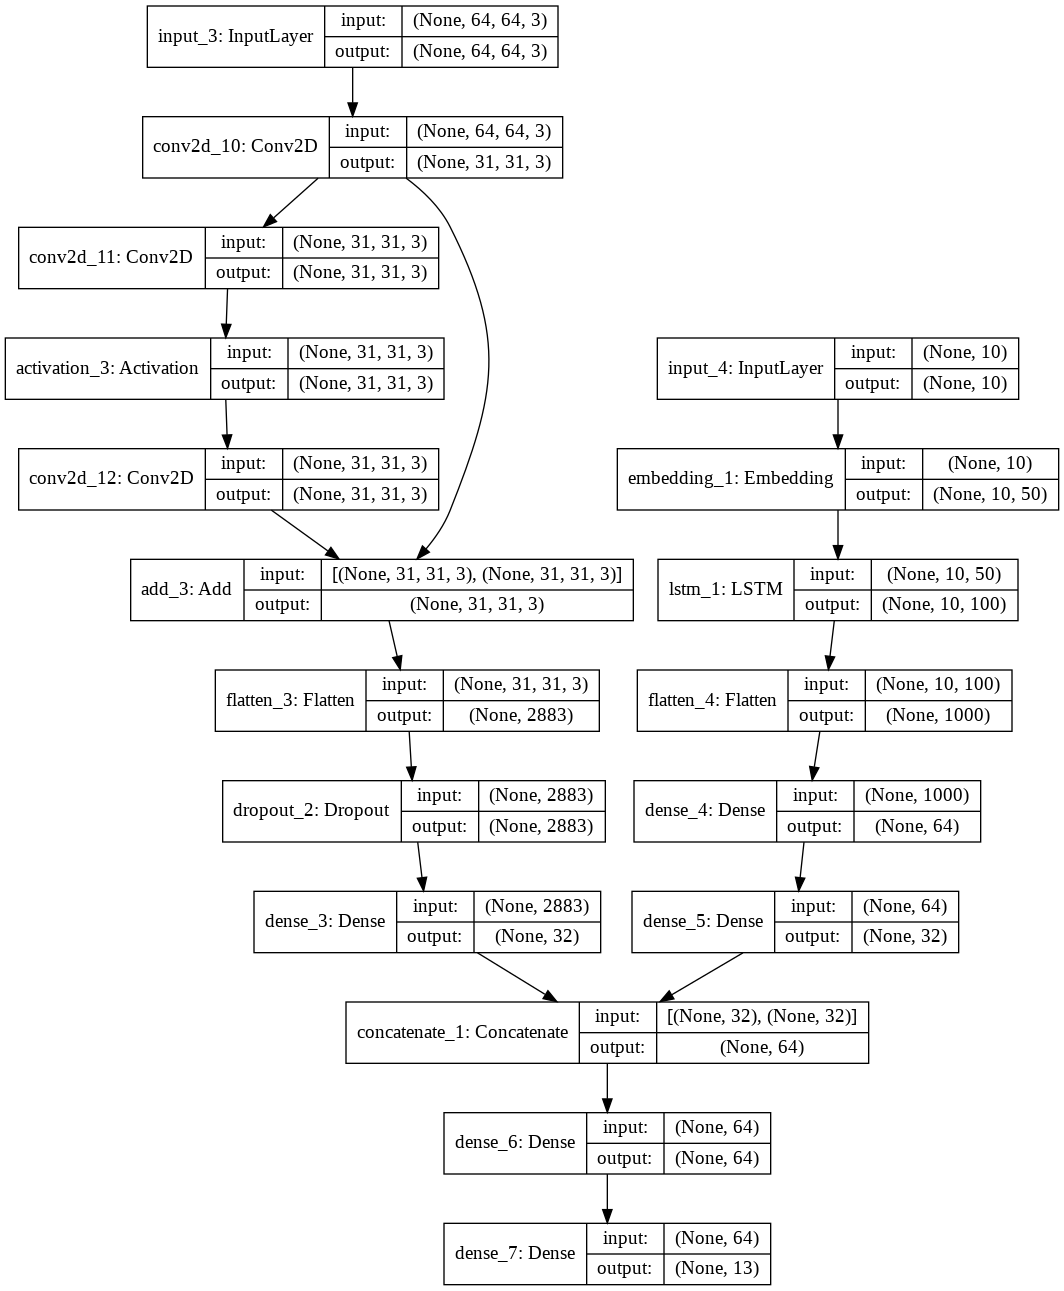

In [20]:
plot_model(model, show_shapes=True)

In [0]:
# Train the model!
history=model.fit(
  # Reminder: train_X_seqs is from this post's BOW section
  [train_X_ims, train_X_seqs],
  train_Y,
  validation_data=([test_X_ims, test_X_seqs], test_Y),
  shuffle=True,
  epochs=10, # somewhat arbitrary, try more epochs if you have time!
  callbacks=[checkpoint],
)

Train on 38575 samples, validate on 9673 samples
Epoch 1/10
38575/38575 [==============================] - 32s 839us/step - loss: 0.7395 - accuracy: 0.6956 - val_loss: 0.5771 - val_accuracy: 0.7514
Epoch 2/10
38575/38575 [==============================] - 32s 818us/step - loss: 0.5502 - accuracy: 0.7623 - val_loss: 0.5329 - val_accuracy: 0.7692
Epoch 3/10
38575/38575 [==============================] - 32s 825us/step - loss: 0.5134 - accuracy: 0.7732 - val_loss: 0.4985 - val_accuracy: 0.7745
Epoch 4/10
38575/38575 [==============================] - 33s 858us/step - loss: 0.4594 - accuracy: 0.7895 - val_loss: 0.4589 - val_accuracy: 0.7873
Epoch 5/10
38575/38575 [==============================] - 33s 854us/step - loss: 0.4146 - accuracy: 0.8033 - val_loss: 0.4439 - val_accuracy: 0.7841
Epoch 6/10
38575/38575 [==============================] - 32s 834us/step - loss: 0.3726 - accuracy: 0.8195 - val_loss: 0.4007 - val_accuracy: 0.8010
Epoch 7/10
38575/38575 [==============================] -

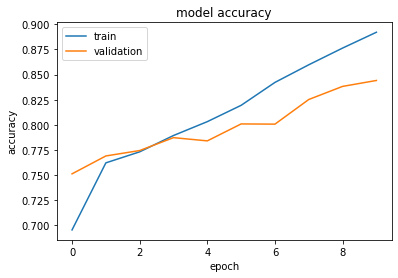

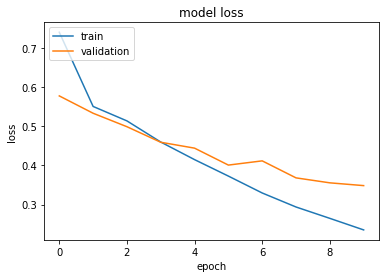

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [0]:
from tensorflow import keras
demoModel = keras.models.load_model((os.path.join(PROJECT_LOC,'glove-LSTM-concat.h5')))

In [43]:
# model.predict


9673


Tensor("input_4:0", shape=(None, 10), dtype=float32)
